In [40]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import pymc as pm
import pytensor.tensor as pt

In [15]:
media = pd.read_csv('data/MMM_test_data.csv', )
media.head()


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


<Axes: title={'center': 'MMM test data'}, xlabel='start_of_week'>

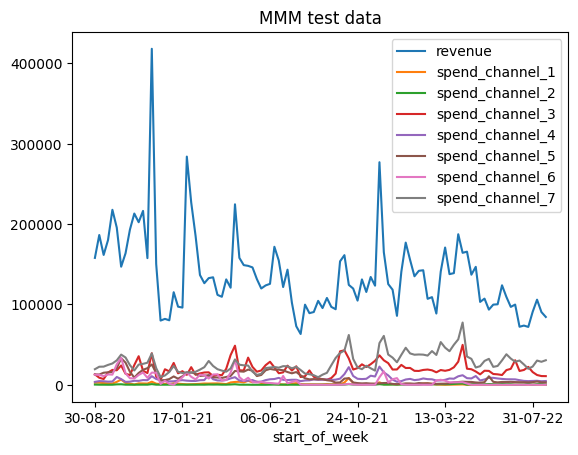

In [16]:
media.plot(x='start_of_week', title='MMM test data', legend=True)

# geometric decay

In [59]:
lag = {
    "spend_channel_1": 2,
    "spend_channel_2": 2,
    "spend_channel_3": 2,
    "spend_channel_4": 2,
    "spend_channel_5": 2,
    "spend_channel_6": 2,
    "spend_channel_7": 2
}

retention_rate = 0.8
retention_length = 13

media_transformed = media.copy()

for i,j in lag.items():
    weights = retention_rate ** (np.flip(np.arange(retention_length + 1) - j)**2)
    weighted_sum = lambda x: np.sum(weights[-x.shape[0]:]*x)
    media_transformed[i] = media[i].rolling(window=retention_length, closed='both', min_periods=1).apply(weighted_sum, raw=False)

<Axes: title={'center': 'MMM test data transformed'}, xlabel='start_of_week'>

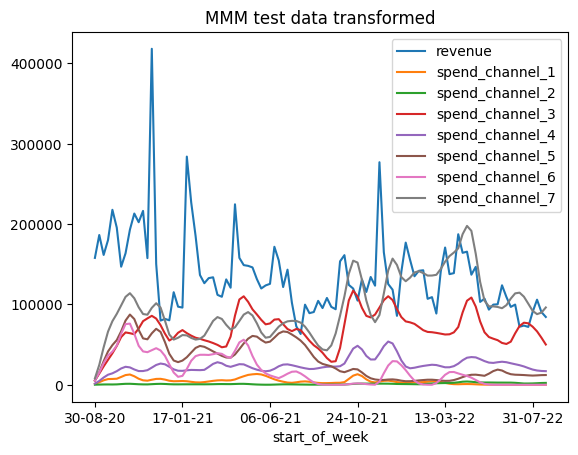

In [60]:
media_transformed.plot(x='start_of_week', title='MMM test data transformed', legend=True)

In [20]:
def hill_transform(x, alpha, gamma):
    return 1 / (1 + (x/gamma)**-alpha)

/var/folders/kr/jy8wf_rj1yl1f9y5bjhmsd_40000gp/T/ipykernel_61893/1646556120.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  return 1 / (1 + (x/gamma)**-alpha)
/var/folders/kr/jy8wf_rj1yl1f9y5bjhmsd_40000gp/T/ipykernel_61893/1646556120.py:2: RuntimeWarning: divide by zero encountered in power
  return 1 / (1 + (x/gamma)**-alpha)


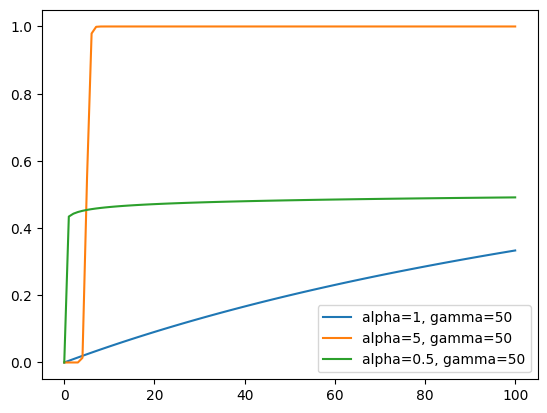

In [34]:
# show the effect of the hill transform
x = np.linspace(0, 100, 100)
y1 = hill_transform(x, 1, 200)
y2 = hill_transform(x, 20, 5)
y3 = hill_transform(x, 0.05, 200)

mpl.pyplot.plot(x, y1, label='alpha=1, gamma=50')
mpl.pyplot.plot(x, y2, label='alpha=5, gamma=50')
mpl.pyplot.plot(x, y3, label='alpha=0.5, gamma=50')
mpl.pyplot.legend()

In [43]:
bias = pd.DataFrame({
    "t": np.arange(104)
})

d = 2

# Fourier terms
for i in np.arange(1,d+1):
    bias[f"cos_{i}"] = np.cos(2 * np.pi * i * bias["t"] / 52)
    bias[f"sin_{i}"] = np.sin(2 * np.pi * i * bias["t"] / 52)

# Holiday flag
bias['holiday_period'] = np.select([bias.t==26, bias.t==78, np.logical_and(bias.t>=40,bias.t<=52), np.logical_and(bias.t>=92,bias.t<=104)],[1,1,1,1],0)

# Min-max scaling
bias.iloc[:,1:] = (bias.iloc[:,1:] - bias.iloc[:,1:].min()) / (bias.iloc[:,1:].max() - bias.iloc[:,1:].min())

/var/folders/kr/jy8wf_rj1yl1f9y5bjhmsd_40000gp/T/ipykernel_61893/575629671.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
99     1.0
100    1.0
101    1.0
102    1.0
103    1.0
Name: holiday_period, Length: 104, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  bias.iloc[:,1:] = (bias.iloc[:,1:] - bias.iloc[:,1:].min()) / (bias.iloc[:,1:].max() - bias.iloc[:,1:].min())


In [44]:
channel_priors = {
    "spend_channel_1": 0.02,
    "spend_channel_2": 0.05,
    "spend_channel_3": 0.02,
    "spend_channel_4": 0.03,
    "spend_channel_5": 0.08,
    "spend_channel_6": 0.14,
    "spend_channel_7": 0.01
}

trend_prior = 0.05
holiday_prior = 0.05
seasonality_prior = 0.05 / (2*d)

In [61]:
def scale(x, y):
  return x * y.sum() / x.sum()

with pm.Model() as mmm:

    target = media['revenue'] / media['revenue'].mean()

    media_contributions = []

    for channel in channel_priors.keys():

        # define coefficient
        channel_prior = channel_priors[channel]
        channel_coefficient = pm.TruncatedNormal(f"coefficient_{channel}", mu=channel_prior, sigma=0.0001, lower=0, upper=0.15)

        # define saturation
        alpha = pm.Uniform(f"alpha_{channel}", lower=0.5, upper=2)
        gamma = pm.Uniform(f"gamma_{channel}", lower=0.5, upper=1.5)

        saturated_media = hill_transform(
            pt.as_tensor_variable(media_transformed[channel] / media_transformed[channel].mean()),
            alpha,
            gamma
        )

        scaled_media = scale(saturated_media, target)

        # contribution
        channel_contribution = pm.Deterministic(f"contribution_{channel}", channel_coefficient * scaled_media)
        media_contributions.append(channel_contribution)

    # controls
    # holiday_coefficient = pm.TruncatedNormal("coefficient_holiday", mu=holiday_prior, sigma=0.0001, lower=0)
    # controls = pm.Deterministic("contribution_holiday", holiday_coefficient * scale(pt.as_tensor_variable(bias['holiday_period']), target))

    # trend
    trend_coefficient = pm.Normal("coefficient_trend", mu=trend_prior, sigma=0.0001)
    trend = pm.Deterministic("contribution_trend", trend_coefficient * pt.as_tensor_variable(target.shift(1).fillna(method='backfill')))

    # seasonality
    seasonality = []
    for i in np.arange(1,d+1):
        coeff_cos = pm.Normal(f"coefficient_seasonality_cos_{i}", mu=seasonality_prior, sigma=0.0001)
        coeff_sin = pm.Normal(f"coefficient_seasonality_sin_{i}", mu=seasonality_prior, sigma=0.0001)
        cos_term = pm.Deterministic(f"contribution_seasonality_cos_{i}", coeff_cos * pt.as_tensor_variable(bias[f"cos_{i}"]) * target.sum()/26)
        sin_term = pm.Deterministic(f"contribution_seasonality_sin_{i}", coeff_sin * pt.as_tensor_variable(bias[f"sin_{i}"]) * target.sum()/26)
        seasonality.extend([cos_term, sin_term])

    noise = pm.Uniform("sigma", lower=0, upper=0.02)
    intercept_coefficient = pm.TruncatedNormal("coefficient_intercept", mu=0.5, sigma=0.0001, lower=0)
    intercept = pm.Deterministic("contribution_intercept", intercept_coefficient * target.mean())

    # define likelihood
    likelihood = pm.Normal("revenue",
                             mu = intercept + trend + sum(seasonality) + sum(media_contributions),
                             sigma = noise,
                             observed=target)

    # inference
    trace = pm.sample(tune=1000)

/var/folders/kr/jy8wf_rj1yl1f9y5bjhmsd_40000gp/T/ipykernel_61893/2726050521.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend = pm.Deterministic("contribution_trend", trend_coefficient * pt.as_tensor_variable(target.shift(1).fillna(method='backfill')))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefficient_spend_channel_1, alpha_spend_channel_1, gamma_spend_channel_1, coefficient_spend_channel_2, alpha_spend_channel_2, gamma_spend_channel_2, coefficient_spend_channel_3, alpha_spend_channel_3, gamma_spend_channel_3, coefficient_spend_channel_4, alpha_spend_channel_4, gamma_spend_channel_4, coefficient_spend_channel_5, alpha_spend_channel_5, gamma_spend_channel_5, coefficient_spend_channel_6, alpha_spend_channel_6, gamma_spend_channel_6, coefficient_spend_channel_7, alpha_spend_channel_7, gamma_spend_channel_7

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/Users/pmengers/Documents/private/haensel-ams/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [53]:
import matplotlib.pyplot as plt

Sampling: [revenue]


Output()

Text(0.5, 1.0, 'Model Fit')

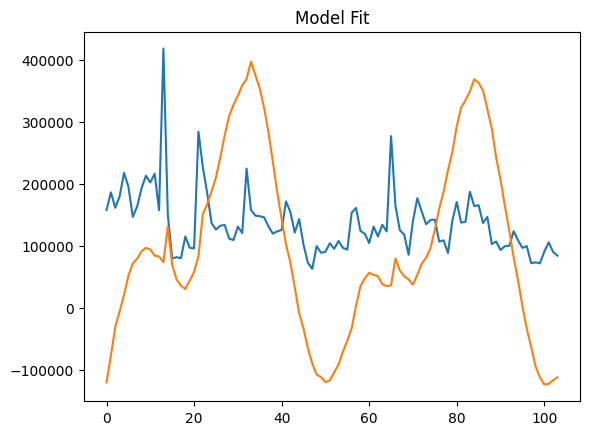

In [62]:
posterior = pm.sample_posterior_predictive(trace, mmm)
predictions = posterior['posterior_predictive']['revenue'].mean(axis=0).mean(axis=0) * media['revenue'].mean()

dates = media['start_of_week']

media_decomp = pd.DataFrame({i:np.array(trace['posterior']["contribution_"+str(i)]).mean(axis=(0,1)) for i in channel_priors.keys()}, index=dates) * media['revenue'].mean()

plt.plot(media['revenue'])
plt.plot(predictions)
plt.title("Model Fit")